## This notebook tests experimental features that will likely change.

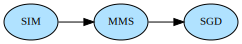

In [1]:
from lale.lib.rasl import SimpleImputer as SIM
from lale.lib.rasl import MinMaxScaler as MMS
from lale.lib.rasl import BatchedBaggingClassifier as BBC
from lale.lib.sklearn import SGDClassifier as SGD
from lale.lib.sklearn import RandomForestClassifier as RFC

def fresh_pipeline(final_est="sgd"):  #create new to guarantee fresh state after earlier fit/partial_fit, if any
    if final_est == "sgd":
        est = SGD(random_state=42)
    elif final_est == "rfc":
        est = RFC(random_state=42)
    elif final_est == "bbc":
        est = BBC()
    return SIM(strategy="mean") >> MMS() >> est

fresh_pipeline().visualize()

In [2]:
from lale.lib.rasl import is_associative, is_incremental, PrioBatch, PrioStep, PrioResourceAware
from lale.lib.rasl import mockup_data_loader, fit_with_batches, cross_val_score
from sklearn.model_selection import KFold

assert is_associative(SIM)
assert is_associative(MMS)
assert is_incremental(SGD)
assert not is_incremental(RFC)

In [3]:
import lale.datasets.openml
import math
import pandas as pd
from lale.lib.lale import Project

(raw_train_X, train_y), (raw_test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)
project = Project(columns={"type": "number"}).fit(raw_train_X)
train_X, test_X = project.transform(raw_train_X), project.transform(raw_test_X)
unique_class_labels = list(train_y.unique())
print(f"unique_class_labels {unique_class_labels}")
train_data_space = train_X.memory_usage().sum() + train_y.memory_usage()
print(f"train_data_space {train_data_space}")
pd.set_option('display.max_rows', 6)
pd.concat([test_y, test_X], axis=1)

/home/hirzel/python3.7venv/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


unique_class_labels ['good', 'bad']
train_data_space 53600


,class,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
993,good,36.0,3959.0,4.0,3.0,30.0,1.0,1.0
859,good,9.0,3577.0,1.0,2.0,26.0,1.0,2.0
298,good,18.0,2515.0,3.0,4.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...
503,bad,24.0,1216.0,4.0,4.0,38.0,2.0,2.0
263,good,12.0,2748.0,2.0,4.0,57.0,3.0,1.0
808,good,42.0,9283.0,1.0,2.0,55.0,1.0,1.0


### Example: no RASL

In [4]:
import lale.lib.rasl

accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

print(f"majority class {len(test_y[test_y == 'good']) / len(test_y):.2%}")
trained = fresh_pipeline().fit(train_X, train_y)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

majority class 70.91%
accuracy 70.91%


### Example: no batching, no cross-validation
- starting point
- behavior equivalent to sklearn
- purposely setting max_resident too low to demonstrate cache warnings

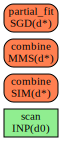

scan INP(d0)


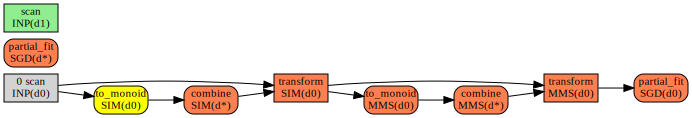

scan INP(d1)
spill /tmp/tmptha11_y2/X_-1_d0_None.pkl /tmp/tmptha11_y2/y_-1_d0_None.pkl


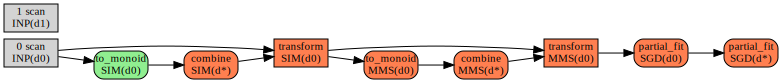

to_monoid SimpleImputer(d0)
load /tmp/tmptha11_y2/X_-1_d0_None.pkl /tmp/tmptha11_y2/y_-1_d0_None.pkl


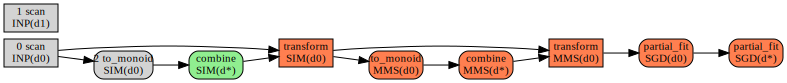

combine SimpleImputer(d*)


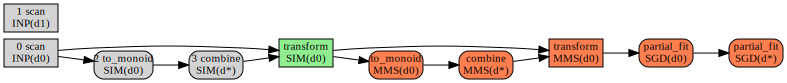

aborted spill of batch -1_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


transform SimpleImputer(d0)


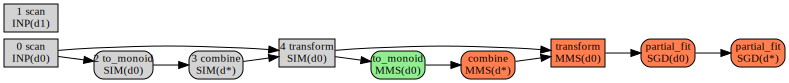

to_monoid MinMaxScaler(d0)


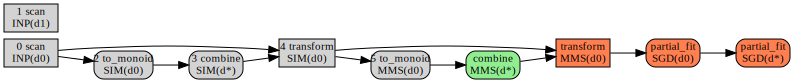

combine MinMaxScaler(d*)


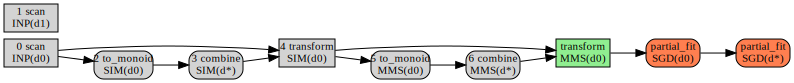

aborted spill of batch 0_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


transform MinMaxScaler(d0)


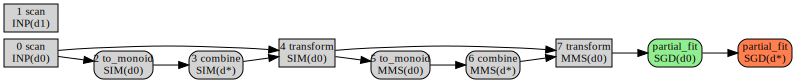

partial_fit SGDClassifier(d0)


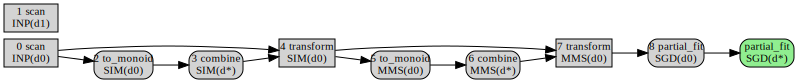

partial_fit SGDClassifier(d*)


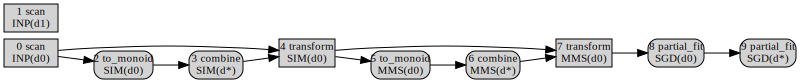

{
    "spill_count": 1,
    "load_count": 1,
    "spill_space": 53600,
    "load_space": 53600,
    "min_resident": 107200,
    "max_resident": 53600,
    "train_count": 6,
    "apply_count": 4,
    "metric_count": 0,
    "train_time": 0.10908770561218262,
    "apply_time": 0.12676405906677246,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.07123184204101562,
}
accuracy 63.33%


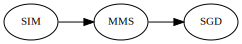

In [5]:
n_batches = 1
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
max_resident = 1 * math.ceil(train_data_space / n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels,
                           max_resident, PrioStep(), partial_transform=False, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")
trained.visualize()

### Example: batching using associativity where possible, non-incremental final estimator

spill /tmp/tmpizl92rla/X_-1_d1_None.pkl /tmp/tmpizl92rla/y_-1_d1_None.pkl
spill /tmp/tmpizl92rla/X_-1_d2_None.pkl /tmp/tmpizl92rla/y_-1_d2_None.pkl
load /tmp/tmpizl92rla/X_-1_d1_None.pkl /tmp/tmpizl92rla/y_-1_d1_None.pkl
load /tmp/tmpizl92rla/X_-1_d2_None.pkl /tmp/tmpizl92rla/y_-1_d2_None.pkl
spill /tmp/tmpizl92rla/X_-1_d2_None.pkl /tmp/tmpizl92rla/y_-1_d2_None.pkl
spill /tmp/tmpizl92rla/X_-1_d1_None.pkl /tmp/tmpizl92rla/y_-1_d1_None.pkl
load /tmp/tmpizl92rla/X_-1_d1_None.pkl /tmp/tmpizl92rla/y_-1_d1_None.pkl
spill /tmp/tmpizl92rla/X_0_d0_None.pkl /tmp/tmpizl92rla/y_0_d0_None.pkl
load /tmp/tmpizl92rla/X_-1_d2_None.pkl /tmp/tmpizl92rla/y_-1_d2_None.pkl
load /tmp/tmpizl92rla/X_0_d0_None.pkl /tmp/tmpizl92rla/y_0_d0_None.pkl
spill /tmp/tmpizl92rla/X_0_d2_None.pkl /tmp/tmpizl92rla/y_0_d2_None.pkl
spill /tmp/tmpizl92rla/X_0_d1_None.pkl /tmp/tmpizl92rla/y_0_d1_None.pkl
load /tmp/tmpizl92rla/X_0_d1_None.pkl /tmp/tmpizl92rla/y_0_d1_None.pkl
spill /tmp/tmpizl92rla/X_1_d0_None.pkl /tmp/tmpizl92rl

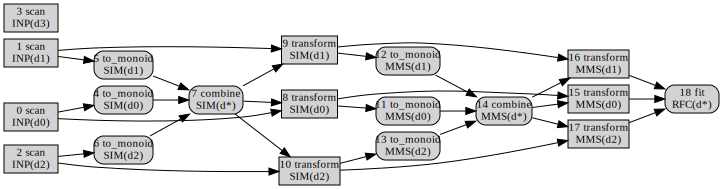

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 9,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.6254985332489014,
    "apply_time": 0.2816612720489502,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.44091248512268066,
}
accuracy 70.30%


In [6]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline("rfc"), batches, None, unique_class_labels,
                           max_resident, PrioStep(), partial_transform=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

### Example: batching using associativity where possible, partial_fit otherwise
- unlike our batching patent, which always used partial_fit
- behavior still equivalent to sklearn
- potential advantages: less resident data; parallelism
- below are three runs with three different scheduling priorities

spill /tmp/tmpmnohzmii/X_-1_d1_None.pkl /tmp/tmpmnohzmii/y_-1_d1_None.pkl
spill /tmp/tmpmnohzmii/X_-1_d2_None.pkl /tmp/tmpmnohzmii/y_-1_d2_None.pkl
load /tmp/tmpmnohzmii/X_-1_d1_None.pkl /tmp/tmpmnohzmii/y_-1_d1_None.pkl
load /tmp/tmpmnohzmii/X_-1_d2_None.pkl /tmp/tmpmnohzmii/y_-1_d2_None.pkl
spill /tmp/tmpmnohzmii/X_-1_d2_None.pkl /tmp/tmpmnohzmii/y_-1_d2_None.pkl
spill /tmp/tmpmnohzmii/X_-1_d1_None.pkl /tmp/tmpmnohzmii/y_-1_d1_None.pkl
load /tmp/tmpmnohzmii/X_-1_d1_None.pkl /tmp/tmpmnohzmii/y_-1_d1_None.pkl
spill /tmp/tmpmnohzmii/X_0_d0_None.pkl /tmp/tmpmnohzmii/y_0_d0_None.pkl
load /tmp/tmpmnohzmii/X_-1_d2_None.pkl /tmp/tmpmnohzmii/y_-1_d2_None.pkl
load /tmp/tmpmnohzmii/X_0_d0_None.pkl /tmp/tmpmnohzmii/y_0_d0_None.pkl
spill /tmp/tmpmnohzmii/X_0_d2_None.pkl /tmp/tmpmnohzmii/y_0_d2_None.pkl
spill /tmp/tmpmnohzmii/X_0_d1_None.pkl /tmp/tmpmnohzmii/y_0_d1_None.pkl
load /tmp/tmpmnohzmii/X_0_d1_None.pkl /tmp/tmpmnohzmii/y_0_d1_None.pkl
spill /tmp/tmpmnohzmii/X_1_d0_None.pkl /tmp/tmpmnohzmi

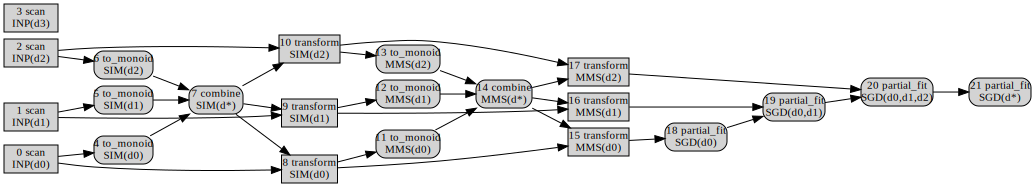

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 12,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.2105693817138672,
    "apply_time": 0.20921802520751953,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.05017495155334473,
}
accuracy 62.42%


In [7]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels, max_resident,
                           PrioStep(), partial_transform=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

spill /tmp/tmpgmv9d5g2/X_-1_d1_None.pkl /tmp/tmpgmv9d5g2/y_-1_d1_None.pkl
spill /tmp/tmpgmv9d5g2/X_-1_d2_None.pkl /tmp/tmpgmv9d5g2/y_-1_d2_None.pkl
load /tmp/tmpgmv9d5g2/X_-1_d1_None.pkl /tmp/tmpgmv9d5g2/y_-1_d1_None.pkl
spill /tmp/tmpgmv9d5g2/X_0_d0_None.pkl /tmp/tmpgmv9d5g2/y_0_d0_None.pkl
load /tmp/tmpgmv9d5g2/X_-1_d2_None.pkl /tmp/tmpgmv9d5g2/y_-1_d2_None.pkl
load /tmp/tmpgmv9d5g2/X_0_d0_None.pkl /tmp/tmpgmv9d5g2/y_0_d0_None.pkl
spill /tmp/tmpgmv9d5g2/X_0_d2_None.pkl /tmp/tmpgmv9d5g2/y_0_d2_None.pkl
spill /tmp/tmpgmv9d5g2/X_0_d1_None.pkl /tmp/tmpgmv9d5g2/y_0_d1_None.pkl
load /tmp/tmpgmv9d5g2/X_0_d1_None.pkl /tmp/tmpgmv9d5g2/y_0_d1_None.pkl
load /tmp/tmpgmv9d5g2/X_0_d2_None.pkl /tmp/tmpgmv9d5g2/y_0_d2_None.pkl


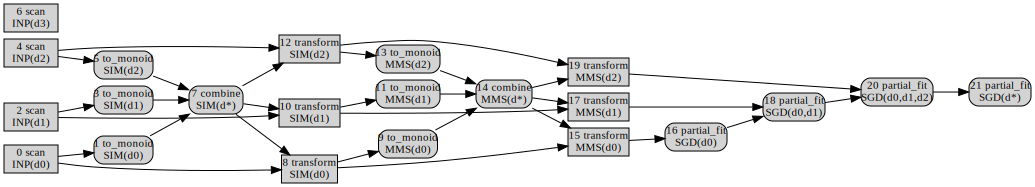

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 12,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.1366872787475586,
    "apply_time": 0.22090864181518555,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.04223322868347168,
}
accuracy 62.42%


In [8]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels, max_resident,
                           PrioBatch(), partial_transform=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

spill /tmp/tmpfmuwmc5k/X_-1_d1_None.pkl /tmp/tmpfmuwmc5k/y_-1_d1_None.pkl
spill /tmp/tmpfmuwmc5k/X_-1_d2_None.pkl /tmp/tmpfmuwmc5k/y_-1_d2_None.pkl
load /tmp/tmpfmuwmc5k/X_-1_d1_None.pkl /tmp/tmpfmuwmc5k/y_-1_d1_None.pkl
spill /tmp/tmpfmuwmc5k/X_0_d0_None.pkl /tmp/tmpfmuwmc5k/y_0_d0_None.pkl
load /tmp/tmpfmuwmc5k/X_-1_d2_None.pkl /tmp/tmpfmuwmc5k/y_-1_d2_None.pkl
load /tmp/tmpfmuwmc5k/X_0_d0_None.pkl /tmp/tmpfmuwmc5k/y_0_d0_None.pkl
spill /tmp/tmpfmuwmc5k/X_1_d2_None.pkl /tmp/tmpfmuwmc5k/y_1_d2_None.pkl
load /tmp/tmpfmuwmc5k/X_1_d2_None.pkl /tmp/tmpfmuwmc5k/y_1_d2_None.pkl


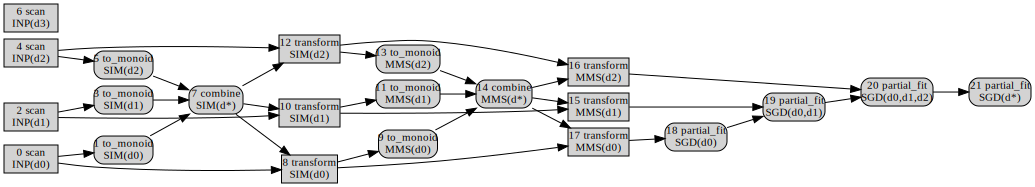

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 12,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.16898250579833984,
    "apply_time": 0.19858717918395996,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.052910804748535156,
}
accuracy 62.42%


In [9]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels, max_resident,
                           PrioResourceAware(), partial_transform=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

### Example: frozen trained prefix

- pre-train on the first batch, then freeze, and train again on remaining batches
- in the second training, SGD partial_fit *i* happens before scan *i+1*
- to test and demonstrate that, setting partial_transform="score"

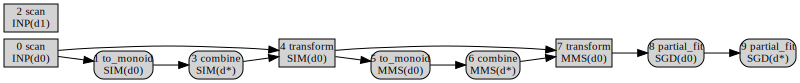

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35840,
    "max_resident": 9223372036854775807,
    "train_count": 6,
    "apply_count": 4,
    "metric_count": 0,
    "train_time": 0.04140877723693848,
    "apply_time": 0.03378415107727051,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.02782917022705078,
}


In [10]:
class DemoProgressCallback:  # ideally, should create a dynamically updating plot in Jupyter
    def __init__(self):
        self.scores = []
    
    def __call__(self, score, n_batches_scanned, end_of_scanned_batches):
        self.scores.append(score)
        scores_s = ", ".join(f"{s:.2%}" for s in self.scores)
        print(f"scanned {n_batches_scanned}, found end {end_of_scanned_batches}, callback state {scores_s}")
        assert len(self.scores) == n_batches_scanned + (1 if end_of_scanned_batches else 0)

n_batches = 3
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
first_batch = next(iter(batches))
trainable1 = fresh_pipeline()
trained1 = fit_with_batches(trainable1, [first_batch], None, unique_class_labels, None,
                            PrioBatch(), partial_transform=False, verbose=2, progress_callback=None)

scanned 1, found end False, callback state 69.96%
scanned 2, found end False, callback state 69.96%, 69.51%


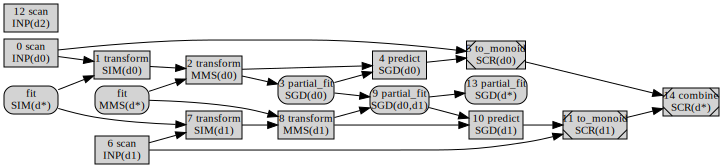

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35680,
    "max_resident": 9223372036854775807,
    "train_count": 3,
    "apply_count": 9,
    "metric_count": 3,
    "train_time": 0.016388654708862305,
    "apply_time": 0.08010983467102051,
    "metric_time": 0.0161893367767334,
    "critical_count": 1,
    "critical_time": 0.01591324806213379,
}


In [11]:
prefix2 = trained1.remove_last().freeze_trained()
suffix2 = trained1.get_last()
trainable2 = prefix2 >> suffix2
trained = fit_with_batches(trainable2, batches, accuracy_scorer, unique_class_labels, None,
                           PrioBatch(), partial_transform="score", verbose=2, progress_callback=DemoProgressCallback())

### Example: partial_transform, start using transformer before it has seen all data
- behavior not equivalent to sklearn, instead more similar to DL
- but may be "close enough" if operators are "convergent"
- advantage: need much less resident data
- amenable to early stopping, extracting a checkpoint

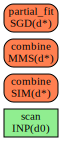

scan INP(d0)


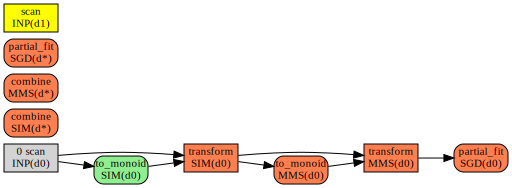

to_monoid SimpleImputer(d0)


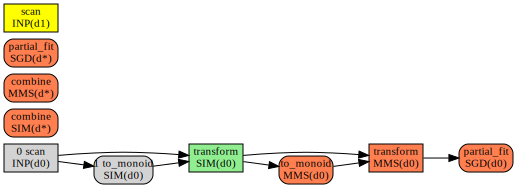

transform SimpleImputer(d0)


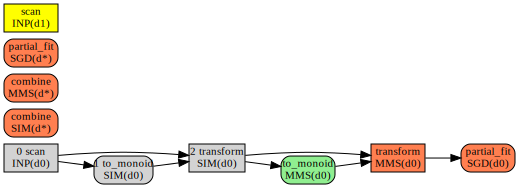

to_monoid MinMaxScaler(d0)


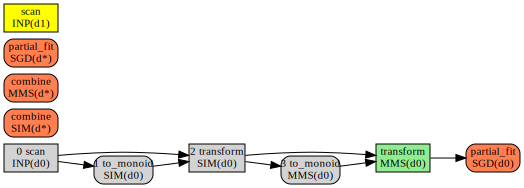

transform MinMaxScaler(d0)


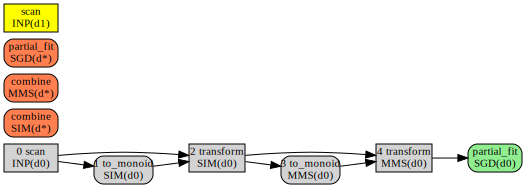

partial_fit SGDClassifier(d0)


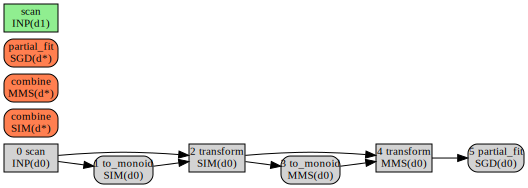

scan INP(d1)


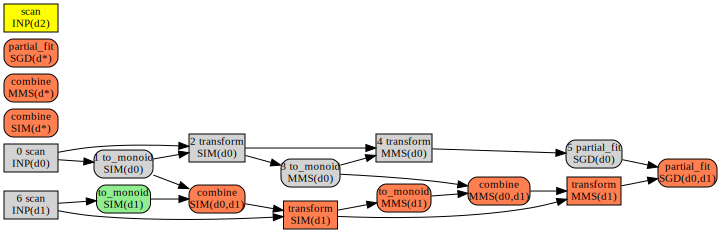

to_monoid SimpleImputer(d1)


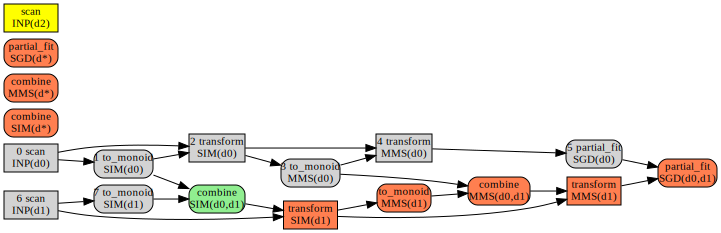

combine SimpleImputer(d0,d1)


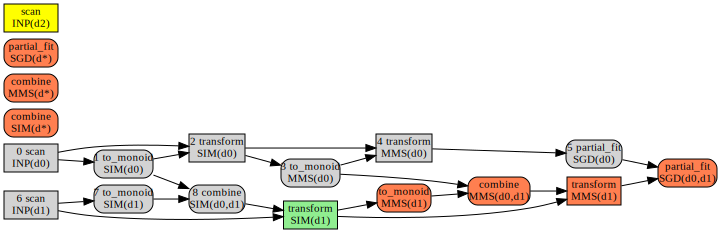

transform SimpleImputer(d1)


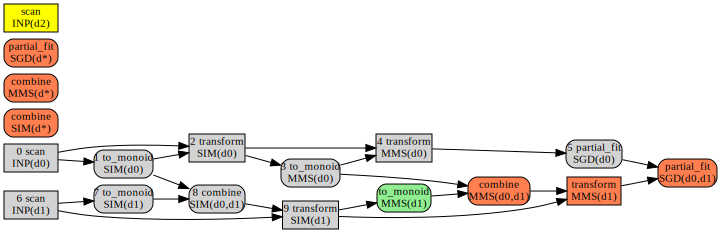

to_monoid MinMaxScaler(d1)


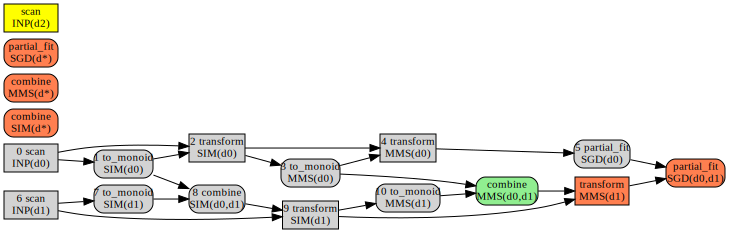

combine MinMaxScaler(d0,d1)


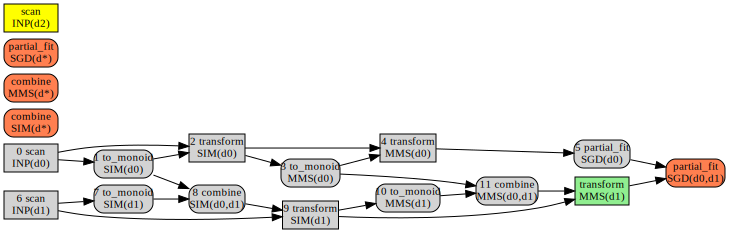

transform MinMaxScaler(d1)


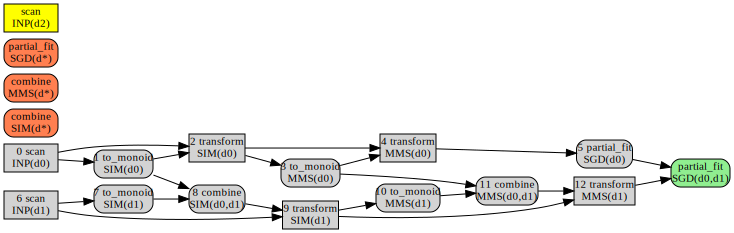

partial_fit SGDClassifier(d0,d1)


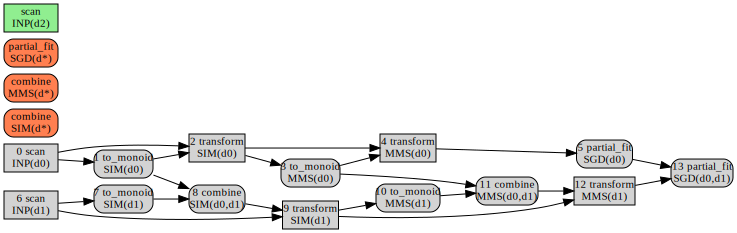

scan INP(d2)


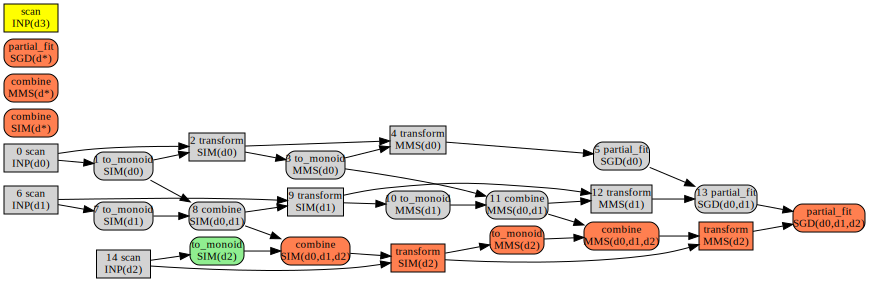

to_monoid SimpleImputer(d2)


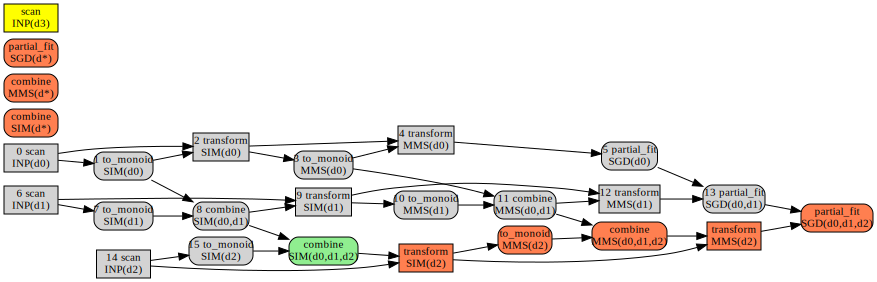

combine SimpleImputer(d0,d1,d2)


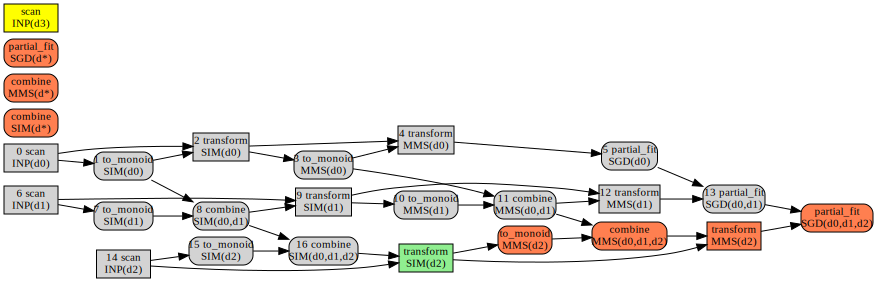

transform SimpleImputer(d2)


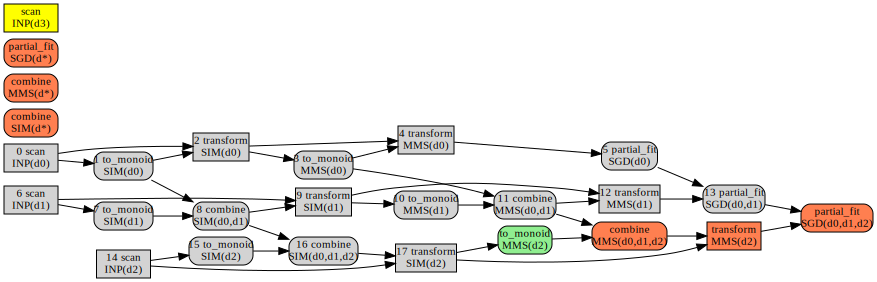

to_monoid MinMaxScaler(d2)


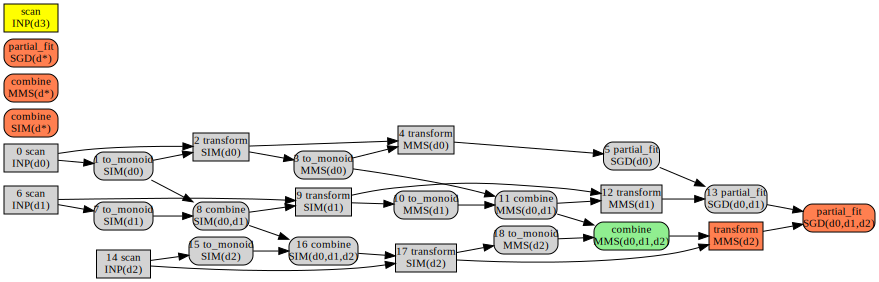

combine MinMaxScaler(d0,d1,d2)


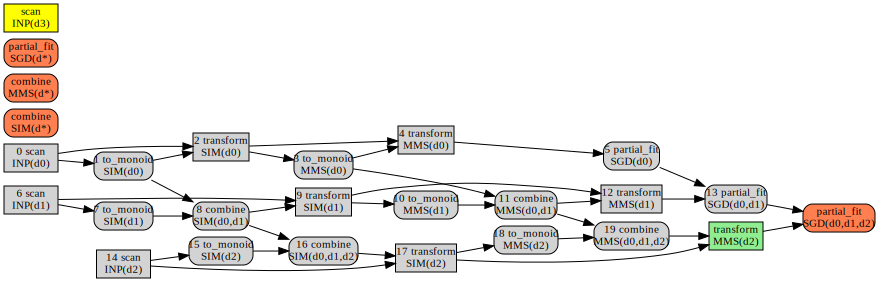

transform MinMaxScaler(d2)


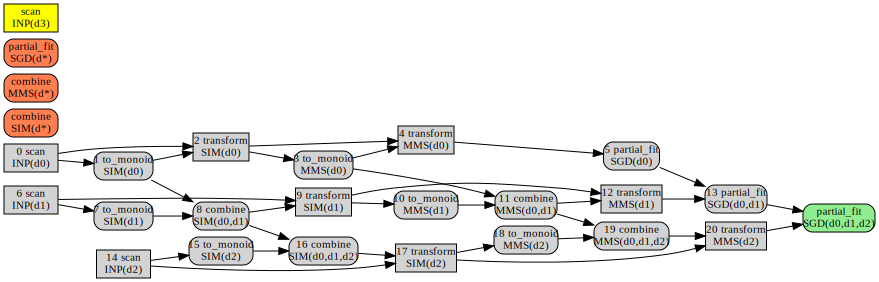

partial_fit SGDClassifier(d0,d1,d2)


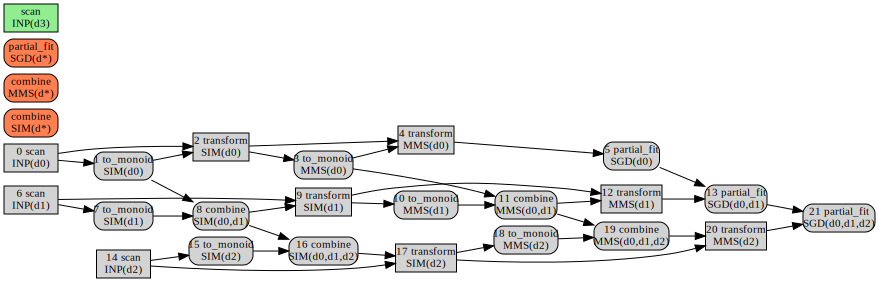

scan INP(d3)


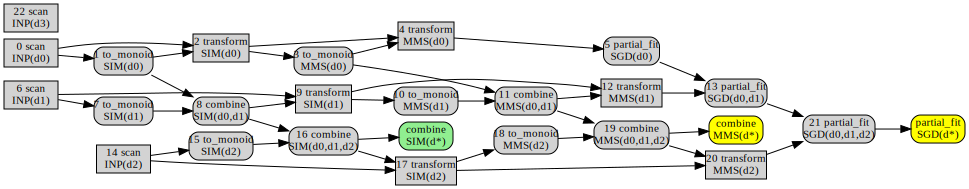

combine SimpleImputer(d*)


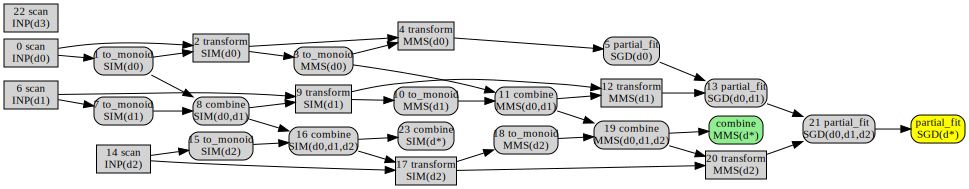

combine MinMaxScaler(d*)


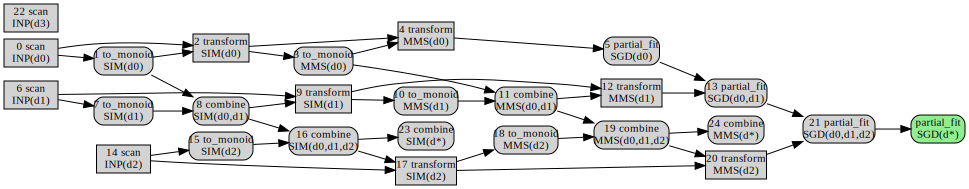

partial_fit SGDClassifier(d*)


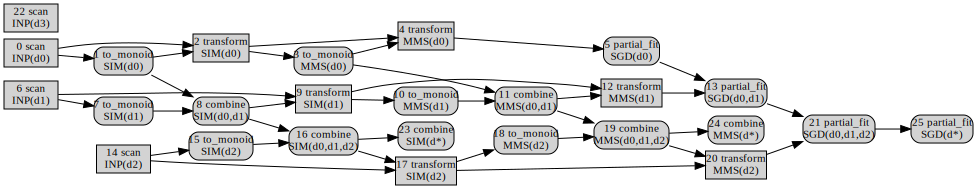

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 16,
    "apply_count": 10,
    "metric_count": 0,
    "train_time": 0.1860201358795166,
    "apply_time": 0.17980647087097168,
    "metric_time": 0,
    "critical_count": 1,
    "critical_time": 0.039456844329833984,
}
accuracy 70.30%


In [12]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, None, unique_class_labels,
                           max_resident, PrioBatch(), partial_transform=True, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

### Example: learning curve during fit_with_batches with partial_transform

spill /tmp/tmpa95hx01d/X_-1_d0_None.pkl /tmp/tmpa95hx01d/y_-1_d0_None.pkl
load /tmp/tmpa95hx01d/X_-1_d0_None.pkl /tmp/tmpa95hx01d/y_-1_d0_None.pkl
scanned 1, found end False, callback state 68.75%
scanned 2, found end False, callback state 68.75%, 69.96%
scanned 3, found end False, callback state 68.75%, 69.96%, 71.30%


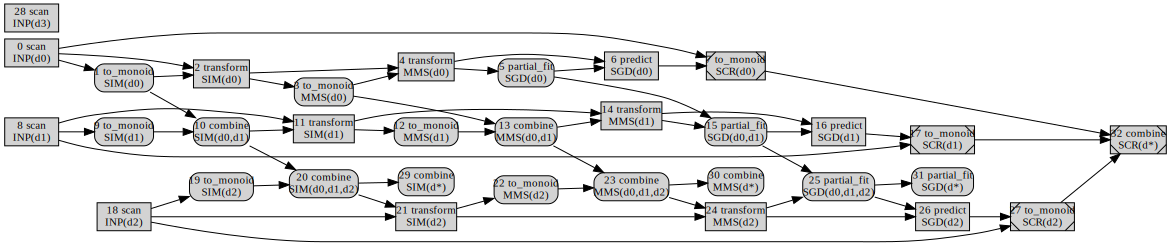

{
    "spill_count": 1,
    "load_count": 1,
    "spill_space": 17920,
    "load_space": 17920,
    "min_resident": 53760,
    "max_resident": 53601,
    "train_count": 16,
    "apply_count": 13,
    "metric_count": 4,
    "train_time": 0.09933137893676758,
    "apply_time": 0.11009407043457031,
    "metric_time": 0.028353452682495117,
    "critical_count": 1,
    "critical_time": 0.028332948684692383,
}
accuracy 70.30%


In [13]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, accuracy_scorer, unique_class_labels,
                           max_resident, PrioBatch(), partial_transform=True, verbose=2, progress_callback=DemoProgressCallback())
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.2%}")

### Example: cross-validation without batching, using same-fold data for training
- behavior equivalent to sklearn
- reuse of lifted coefficients limited to first operator
- disambiguate some tasks by `\f`, where f is the left-out fold
- using associativity where possible, partial_fit otherwise

spill /tmp/tmpszv7qfdx/X_-1_d0_None.pkl /tmp/tmpszv7qfdx/y_-1_d0_None.pkl
spill /tmp/tmpszv7qfdx/X_0_e0_f.pkl /tmp/tmpszv7qfdx/y_0_e0_f.pkl
spill /tmp/tmpszv7qfdx/X_-1_e0_None.pkl /tmp/tmpszv7qfdx/y_-1_e0_None.pkl
load /tmp/tmpszv7qfdx/X_-1_e0_None.pkl /tmp/tmpszv7qfdx/y_-1_e0_None.pkl
spill /tmp/tmpszv7qfdx/X_-1_f0_None.pkl /tmp/tmpszv7qfdx/y_-1_f0_None.pkl
spill /tmp/tmpszv7qfdx/X_0_f0_e.pkl /tmp/tmpszv7qfdx/y_0_f0_e.pkl
load /tmp/tmpszv7qfdx/X_-1_d0_None.pkl /tmp/tmpszv7qfdx/y_-1_d0_None.pkl
spill /tmp/tmpszv7qfdx/X_0_f0_f.pkl /tmp/tmpszv7qfdx/y_0_f0_f.pkl
spill /tmp/tmpszv7qfdx/X_-1_e0_None.pkl /tmp/tmpszv7qfdx/y_-1_e0_None.pkl
spill /tmp/tmpszv7qfdx/X_-1_d0_None.pkl /tmp/tmpszv7qfdx/y_-1_d0_None.pkl
load /tmp/tmpszv7qfdx/X_0_e0_f.pkl /tmp/tmpszv7qfdx/y_0_e0_f.pkl
load /tmp/tmpszv7qfdx/X_0_f0_e.pkl /tmp/tmpszv7qfdx/y_0_f0_e.pkl
load /tmp/tmpszv7qfdx/X_-1_e0_None.pkl /tmp/tmpszv7qfdx/y_-1_e0_None.pkl
load /tmp/tmpszv7qfdx/X_0_f0_f.pkl /tmp/tmpszv7qfdx/y_0_f0_f.pkl
load /tmp/tmpszv7q

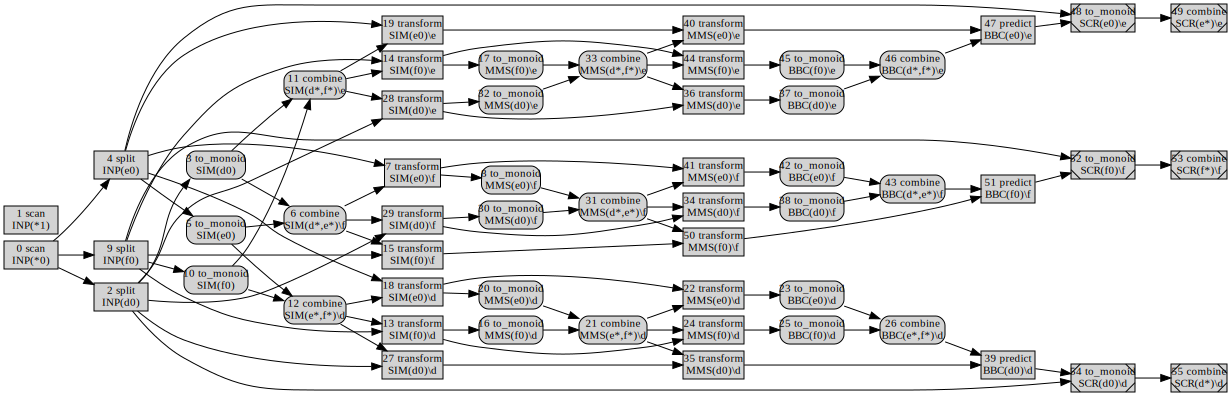

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 24,
    "apply_count": 26,
    "metric_count": 6,
    "train_time": 0.14207005500793457,
    "apply_time": 0.8713393211364746,
    "metric_time": 0.07103753089904785,
    "critical_count": 1,
    "critical_time": 0.20865416526794434,
}
accuracies 52.68%, 54.26%, 53.36%


In [14]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("bbc"), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.2%}" for score in scores))

### Example: cross-validation with batching, using same-fold data for training
- compared to cross-validation without batching, requires less resident memory

spill /tmp/tmpjrgwz4y5/X_-1_*1_None.pkl /tmp/tmpjrgwz4y5/y_-1_*1_None.pkl
spill /tmp/tmpjrgwz4y5/X_-1_d0_None.pkl /tmp/tmpjrgwz4y5/y_-1_d0_None.pkl
spill /tmp/tmpjrgwz4y5/X_-1_e0_None.pkl /tmp/tmpjrgwz4y5/y_-1_e0_None.pkl
load /tmp/tmpjrgwz4y5/X_-1_*1_None.pkl /tmp/tmpjrgwz4y5/y_-1_*1_None.pkl
spill /tmp/tmpjrgwz4y5/X_-1_f0_None.pkl /tmp/tmpjrgwz4y5/y_-1_f0_None.pkl
spill /tmp/tmpjrgwz4y5/X_-1_d1_None.pkl /tmp/tmpjrgwz4y5/y_-1_d1_None.pkl
spill /tmp/tmpjrgwz4y5/X_0_e1_f.pkl /tmp/tmpjrgwz4y5/y_0_e1_f.pkl
spill /tmp/tmpjrgwz4y5/X_-1_e1_None.pkl /tmp/tmpjrgwz4y5/y_-1_e1_None.pkl
load /tmp/tmpjrgwz4y5/X_-1_f0_None.pkl /tmp/tmpjrgwz4y5/y_-1_f0_None.pkl
spill /tmp/tmpjrgwz4y5/X_-1_f1_None.pkl /tmp/tmpjrgwz4y5/y_-1_f1_None.pkl
spill /tmp/tmpjrgwz4y5/X_0_f1_f.pkl /tmp/tmpjrgwz4y5/y_0_f1_f.pkl
spill /tmp/tmpjrgwz4y5/X_0_f1_e.pkl /tmp/tmpjrgwz4y5/y_0_f1_e.pkl
load /tmp/tmpjrgwz4y5/X_-1_d0_None.pkl /tmp/tmpjrgwz4y5/y_-1_d0_None.pkl
spill /tmp/tmpjrgwz4y5/X_0_f1_d.pkl /tmp/tmpjrgwz4y5/y_0_f1_d.pkl

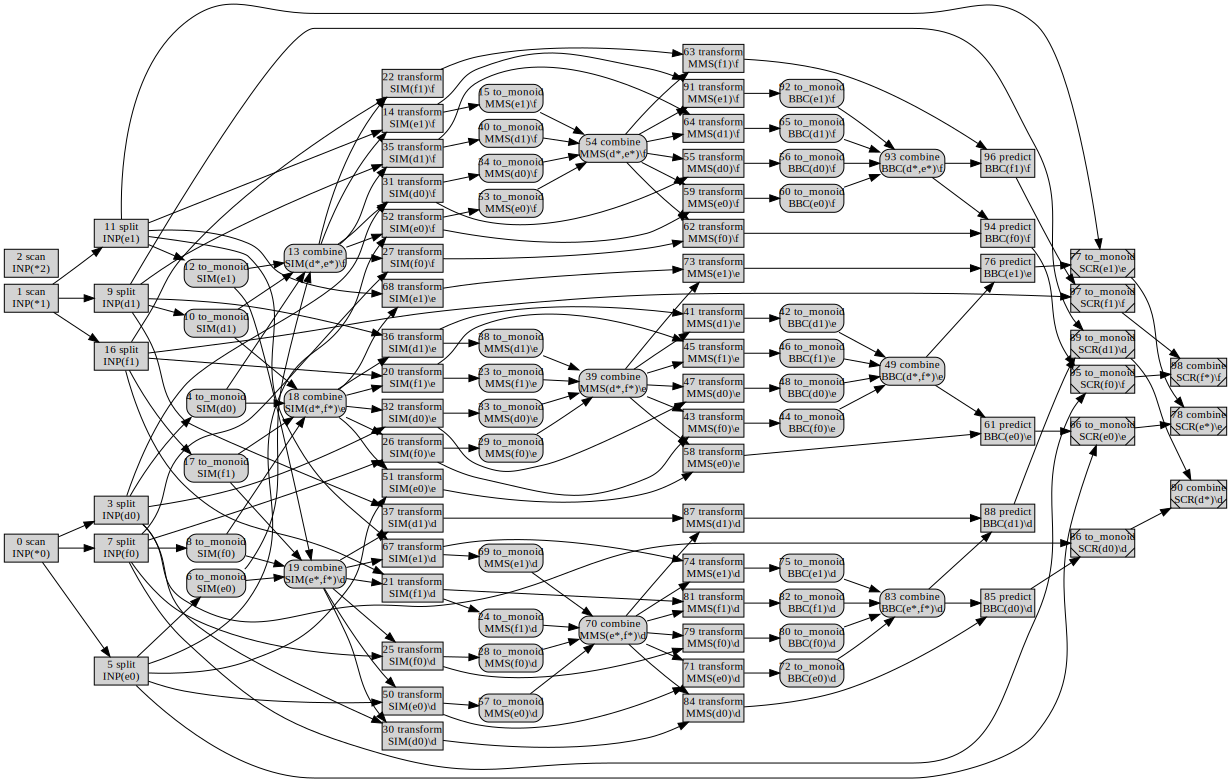

{
    "spill_count": 23,
    "load_count": 23,
    "spill_space": 223120,
    "load_space": 223120,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 39,
    "apply_count": 51,
    "metric_count": 9,
    "train_time": 0.3061833381652832,
    "apply_time": 1.5472698211669922,
    "metric_time": 0.1426839828491211,
    "critical_count": 1,
    "critical_time": 0.1531200408935547,
}
accuracies 59.82%, 57.59%, 61.26%


In [15]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("bbc"), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.2%}" for score in scores))

### Example: cross-validation with out-of-fold samples
- not sklearn compatible
- might generalize better by following best practices for stacking ensembles
- depends on transformers being convergent
- fewer tasks overall than for cross-validation with in-fold samples

spill /tmp/tmp_af_399l/X_-1_d0_None.pkl /tmp/tmp_af_399l/y_-1_d0_None.pkl
spill /tmp/tmp_af_399l/X_-1_e0_None.pkl /tmp/tmp_af_399l/y_-1_e0_None.pkl
load /tmp/tmp_af_399l/X_-1_e0_None.pkl /tmp/tmp_af_399l/y_-1_e0_None.pkl
load /tmp/tmp_af_399l/X_-1_d0_None.pkl /tmp/tmp_af_399l/y_-1_d0_None.pkl
spill /tmp/tmp_af_399l/X_-1_f0_None.pkl /tmp/tmp_af_399l/y_-1_f0_None.pkl
spill /tmp/tmp_af_399l/X_-1_e0_None.pkl /tmp/tmp_af_399l/y_-1_e0_None.pkl
load /tmp/tmp_af_399l/X_-1_e0_None.pkl /tmp/tmp_af_399l/y_-1_e0_None.pkl
load /tmp/tmp_af_399l/X_-1_f0_None.pkl /tmp/tmp_af_399l/y_-1_f0_None.pkl


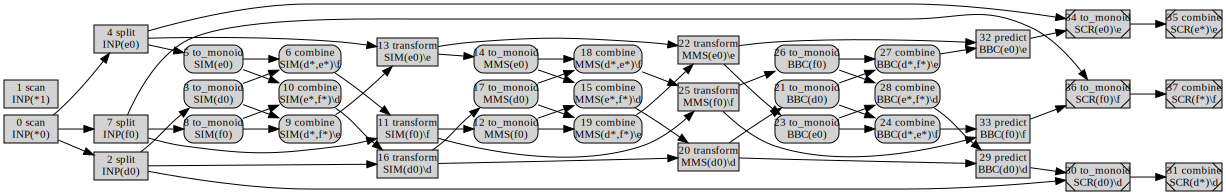

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 14,
    "metric_count": 6,
    "train_time": 0.11627554893493652,
    "apply_time": 0.7141995429992676,
    "metric_time": 0.04137110710144043,
    "critical_count": 1,
    "critical_time": 0.20610380172729492,
}
accuracies 55.80%, 53.81%, 53.36%


In [16]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("bbc"), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.2%}" for score in scores))

spill /tmp/tmp_xw81kfd/X_-1_*1_None.pkl /tmp/tmp_xw81kfd/y_-1_*1_None.pkl
spill /tmp/tmp_xw81kfd/X_-1_d0_None.pkl /tmp/tmp_xw81kfd/y_-1_d0_None.pkl
spill /tmp/tmp_xw81kfd/X_-1_e0_None.pkl /tmp/tmp_xw81kfd/y_-1_e0_None.pkl
load /tmp/tmp_xw81kfd/X_-1_*1_None.pkl /tmp/tmp_xw81kfd/y_-1_*1_None.pkl
spill /tmp/tmp_xw81kfd/X_-1_f0_None.pkl /tmp/tmp_xw81kfd/y_-1_f0_None.pkl
spill /tmp/tmp_xw81kfd/X_-1_d1_None.pkl /tmp/tmp_xw81kfd/y_-1_d1_None.pkl
spill /tmp/tmp_xw81kfd/X_-1_e1_None.pkl /tmp/tmp_xw81kfd/y_-1_e1_None.pkl
load /tmp/tmp_xw81kfd/X_-1_f0_None.pkl /tmp/tmp_xw81kfd/y_-1_f0_None.pkl
load /tmp/tmp_xw81kfd/X_-1_d0_None.pkl /tmp/tmp_xw81kfd/y_-1_d0_None.pkl
spill /tmp/tmp_xw81kfd/X_-1_f1_None.pkl /tmp/tmp_xw81kfd/y_-1_f1_None.pkl
load /tmp/tmp_xw81kfd/X_-1_d1_None.pkl /tmp/tmp_xw81kfd/y_-1_d1_None.pkl
spill /tmp/tmp_xw81kfd/X_0_f1_f.pkl /tmp/tmp_xw81kfd/y_0_f1_f.pkl
spill /tmp/tmp_xw81kfd/X_-1_f0_None.pkl /tmp/tmp_xw81kfd/y_-1_f0_None.pkl
spill /tmp/tmp_xw81kfd/X_0_f0_f.pkl /tmp/tmp_xw81k

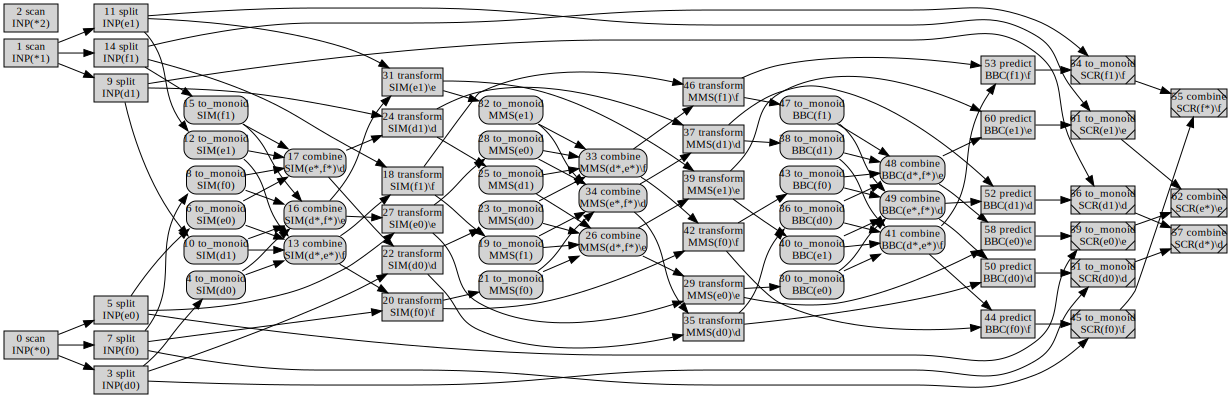

{
    "spill_count": 15,
    "load_count": 15,
    "spill_space": 151840,
    "load_space": 151840,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 27,
    "apply_count": 27,
    "metric_count": 9,
    "train_time": 0.18472599983215332,
    "apply_time": 1.0992286205291748,
    "metric_time": 0.0883791446685791,
    "critical_count": 1,
    "critical_time": 0.18035507202148438,
}
accuracies 67.41%, 60.71%, 56.31%


In [17]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("bbc"), batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.2%}" for score in scores))